# Real Estate Finance

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import fix_yahoo_finance
import yfinance as yf
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
from IPython.display import Image
import urllib.request as url
import io
import datetime as dt
from fredapi import Fred
fred = Fred(api_key='30e6ecb242a73869e11cb35f6aa3afc3')

Populating the interactive namespace from numpy and matplotlib


# What Is the Difference Between Finance and Economics?
* At its core, economics studies **decision-making** in the face of **budget constraints** and **uncertainty**.
    * What are **budget constraints**?
    * What is **uncertainty**?



* **Finance** is a branch of economics.
    * Finance addresses ideas in **portfolio optimization**.  
    * A **portfolio** is a collection of assets whose returns are potentially correlated (either positively or negatively).  
    * In an idealized world, the holder of a portfolio can **buy** or **sell** assets to adjust the portfolio in very small increments **without fees or taxes** and without affecting asset **prices**.
    * As we will see, decisions are driven by the correlation patterns in returns and is called **diversification**.
    * The ideas can be applied to CRE, but the underlying market **microstructure** is different.  **Location, location, location** or **brick-by-brick and block-by-block**.  I like to say either L$^3$ or b$\cdot 6$.




# Three Empirical Regularities Relevant for CRE

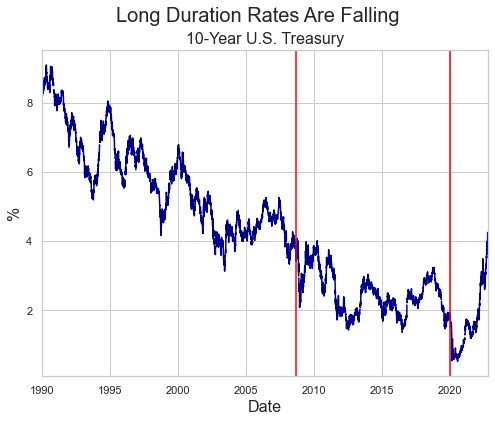

In [2]:
ten_year = fred.get_series("DGS10", observation_start='1990-01-01')
one_year = fred.get_series("DGS1", observation_start='1990-01-01')
three_month = fred.get_series("DGS3MO", observation_start='1990-01-01')

ten_year.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Long Duration Rates Are Falling', fontsize=20)
plt.title('10-Year U.S. Treasury', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")
plt.axvline(dt.datetime(2020, 1, 1), color="red")

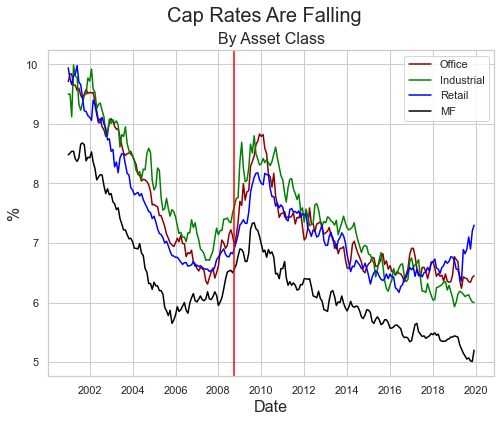

In [3]:
cap_rates = pd.read_excel("cap rates.xls", index_col='Date')
cap_rates = cap_rates.drop(['GT10'], axis=1)
cap_rates = cap_rates.rename(columns={"Retail":"R", "Multifam":"M", "Indust":"I", "Office":"O"})

plt.figure(figsize = (8, 6))
plt.suptitle("Cap Rates Are Falling", fontsize=20)
plt.title("By Asset Class", fontsize=16)
plt.plot(cap_rates['O'], label='Office', c='darkred')
plt.plot(cap_rates['I'], label='Industrial', c='green')
plt.plot(cap_rates['R'], label='Retail', c='blue')
plt.plot(cap_rates['M'], label='MF', c='black')
plt.legend()
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 10, 1), color="red")

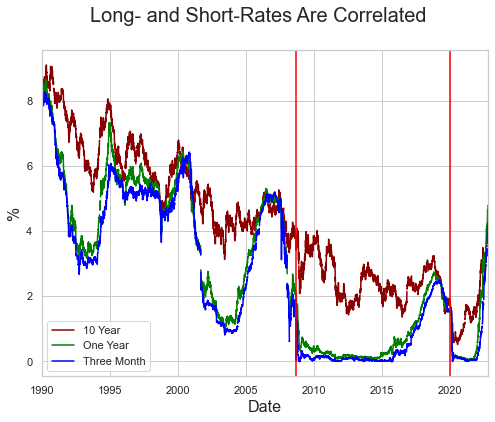

In [4]:
ten_year.plot(c='darkred', label='10 Year', figsize=(8, 6), )
one_year.plot(c='green', label='One Year')
three_month.plot(color='blue', label='Three Month')
plt.suptitle('Long- and Short-Rates Are Correlated', fontsize=20)
plt.legend()
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")
plt.axvline(dt.datetime(2020, 1, 1), color="red")

# Chapter Overview Slides (based on Geltner et al.)

# Chapter 1: Real Estate Economics

## Economics
* Demand
* Supply
* Equilibrium
* Comparative dynamics
* The remainder of this course

### The Economics of Supply and Demand
* Supply and demand curves are abstractions (or representations) used to study markets.
* They are unobserved and unobservable (even by economists).
* The theory of revealed preference: we observe what firms and individuals do (faced with constraints and uncertainty).
* Supply = demand is an **equilibrium condition**:
    * $\Rightarrow \{P^*, Q^*\}$ is an equilibrium.
* Comparative dynamics examine how **one change** impacts an equilibrium.
* **Never Reason from a Price Change**.
    * Why?  Without further exploration, we do not know whether it arose from a demand-curve shift or a supply-curve shift.

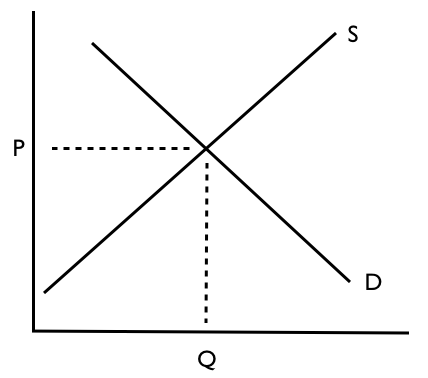

In [5]:
url = 'https://upload.wikimedia.org/wikipedia/commons/4/48/Supply-Demand-Graph.png'
Image(url, width=400, height=400)

## Finance and Its Functions
* A branch of economics that studies financial markets.



* Prices are interest rates or equity prices.
    * Focus is on yields or returns.



* Demand is the demand for capital to deploy to its *highest and best use*, faced with risk and uncertainty.



* At its core, its function to match time preferences of the supply of capital (savers) and the demand for capital (investors).
    * Many intermediaries: Banks.
    * Banks borrow short and lend long.
    * Banks borrow liquid and lend illiquid.
        * A major source of risk is **simply time**.

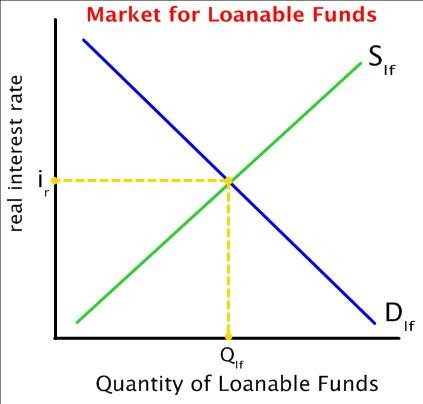

In [6]:
#from IPython.display import Image
url = 'https://sbhshgovapmacro.files.wordpress.com/2011/04/loanable-funds-graph.jpg'
Image(url, width=400, height=400)

## Important Market Distinctions
* Commodity markets (agriculture)



* Equity markets (stocks)



* Debt markets (bonds)



* Space markets (commercial real estate)
    * Traditional asset types: office, industrial, retail and multifamily.
    * Owners/landlords are supply. 
    * Tenants are demand.
    * Brokers are market makers. 
        * Traditional ten-year leases and relationship management.
    * Capital markets are **largely undifferentiated** flows of capital (absent, say, of government controls).
    * Real estate markets are **highly differentiated**, constituted of long-lived assets.
        * Total returns on the asset are rents (income) plus price appreciation (yield).
        * Income is driven by **local** conditions.
        * Yield is driven by **global** conditions.
    * Investor interest in real estate lies in the potential of **uncorrelated returns** (relative to a benchmark).
    * Space markets are, however, highly susceptible to **technological disruption**.
        * E-commerce and industrial/retail/multifamily.
        * Co-working and office.
        * Sharing economy and multifamily.
        * Emergence of niche real estate offerings, such as assisted living, self storage and student housing.

## Physical Demand for Real Estate
* Contrast with investor demand for real estate.



* Physical demand is driven largely by employment growth in the short run.
    * **Torto** and **Wheaton** have shown that near-term performance in rents and vacancy is driven by employment growth.

## Physical Supply of Real Estate
* Physics creates a kinked supply curve. 
    * Time from blueprint to construction to pre-leasing to lease up.
    * Space tends to be added rather than deducted from the physical stock.



* Employment growth has no impact on supply **until it does**.
    * Long Run Marginal Cost Curve (LRMC), an approximation to a supply curve.
        * Baseline: rent sufficient to maintain stock $\Rightarrow$ flat LRMC.
        * Rising: a unit of space becomes **ever more** costly due, for example, to physical constraints (land) or regulation (zoning).
        * Falling: less costly to build due to technological improvement (exogenous) or declining demand for a location (endogenous).  
            * Contrast Midtown with Hudson Yards.

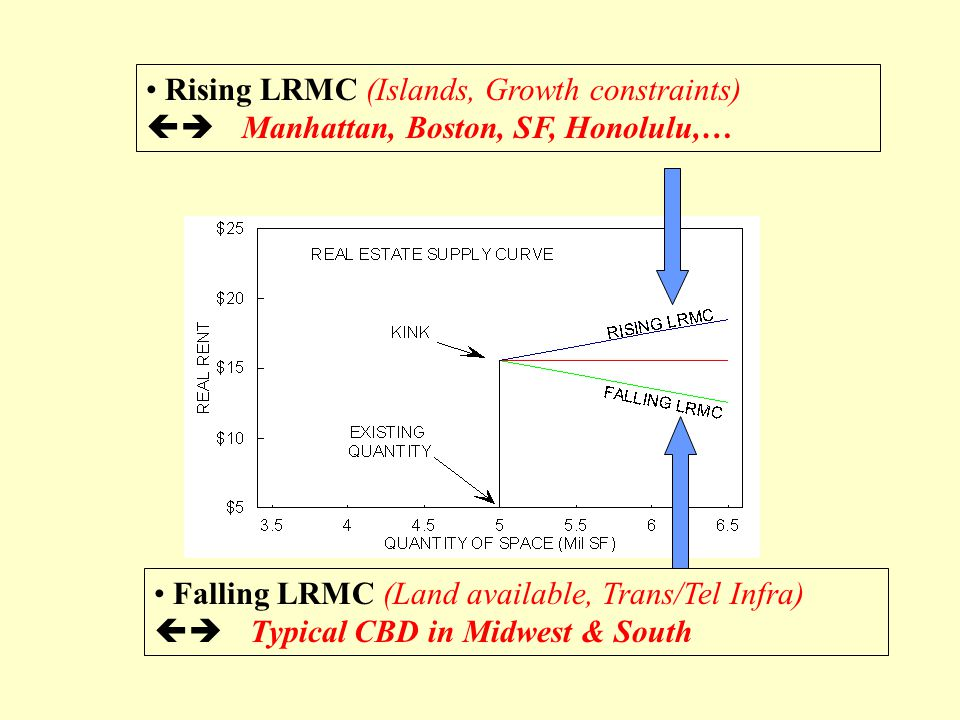

In [7]:
url = 'https://slideplayer.com/slide/5761193/19/images/21/Rising+LRMC+%28Islands%2C+Growth+constraints%29.jpg'
Image(url, width=800, height=800)

## Capital Markets
* Core ideas of capital markets laid out by Walter Bagehot in *Lombard Street*.
    * Borrowing liquid and lending illiquid.
    * Borrowing short and lending long.
    * Essentially, a conversion of time and risk preferences.
    * Presented the notion of the lender of last resort, a role played by the Bank of England (at the time).
        * Lend freely, but at a high rate of interest to organizations or individuals with "good banking securities" (good collateral).




## Capital Markets for CRE
* In CRE, capital markets are global.
    * They may be informationally inefficient when compared with **public** bond and equity markets.



* But real estate remains a physical, local and largely immovable asset.



* The purpose of capital markets is to clear capital so that it is put to its **highest and best use**.



* Many risks associated with borrowing and lending:
    * Construction of real estate remains localized (and differentiated) while capital is global (and undifferentiated).

# Chapter 2: The DiPasquale and Wheaton (DW) Four-Quadrant Model
* To examine the development of physical space (the built environment), we must unify space and asset markets.
    1. Space markets: See Chapter 1.
    2. Capital markets: Capital for development, driven by rents and vacancy, that in turn drive cash flows and net operating income (NOI).
    3. Local economic and regualatory conditions: if demand is rising, driving up short-term rents and driving down vacancy, there are profitable entry conditions.  **New contruction**.
    4. Forecasting: a major component in the industry, but increasingly automated and commoditized with a poor track record.  **CBRE's Richard Barkham in fall 2019 on 2020: "good but not great growth"** when faced with a negative yield curve and Fed intervention in overnight lending markets.  

## The DiPasquale and Wheaton (DW) Model: Tying the Components Together
> "All models are wrong.  Some models are useful."  George Box



* Logical abstraction to assist in thinking about how CRE markets behave.



* Representation of the model.
    * Begin with a market that is in equilibrium (or **steady state**).
    * Create an exogenous shock to evaluate the short-run and long-run implications.
    * In economics and finance, this is called **comparative dynamics**.

## Initial Equilibrium in the DW Model
* Characterized by the tuple: $\{R^*, Q^*, C^*, P^*\}$
* In words,
    * Demand is stable (in equilibrium)
    * Supporting rents at $R^*$ and stock at $Q^*$
    * Based on construction of $C^*$
    * Yielding NOI such that $P^*$ obtains

## Exogenous Shock 1: Demand for Physical Space Increases
* $D_0 \rightarrow D_1$

### Short-Run Implications

1. Stock is fixed at $Q^*$
2. $D_0 \rightarrow D_1 \Rightarrow R^* \rightarrow R_1 \Rightarrow P^* \rightarrow P_1$

### Long-Run Implications

1. Profitable entry $\Rightarrow C^* \rightarrow C^{**} \Rightarrow Q^* \rightarrow Q^{**}$
2. $R_1 \rightarrow R^{**} \Rightarrow P_1 \rightarrow P^{**}$
3. New equilibrium: $\{R^{**}, Q^{**}, C^{**}, P^{**}\}$

## Exogenous Shock 2: Investor Preferences for Real Estate Increase
* $D_0 \rightarrow D_1$

### Short-Run Implications

1. $D_0 \rightarrow D_1 \Rightarrow P^* \rightarrow P_1$: values rise as more capital chases a fixed supply of stock
2. Given fixed NOI, cap rates fall from "11% to 8%"
    * NB: Obviously 8% cap rates are currently unrealistic in gateway markets worldwide

### Long-Run Implications

1. Construction boom $\Rightarrow C^* \rightarrow C^{**} \Rightarrow Q^* \rightarrow Q^{**}$
2. Given fixed demand for physical space, $\Rightarrow R^* \rightarrow R^{**}$
3. Resulting in a decline in NOI, $\Rightarrow P_1 \rightarrow P^{**}$
4. New equilibrium: $\{R^{**}, Q^{**}, C^{**}, P^{**}\}$ characterized by:
    * $R^{**} < R^*$ lower rents
    * $Q^{**} > Q^*$ larger stock
    * $C^{**} > C^*$ larger contruction
    * $P^{**} > P^*$ slightly higher implied values (and lower cap rates)

### Discussion
* The DW model provides a logical framework to consider the four components that comprise real estate markets.
    * It is an abstraction from reality.



* Demand for phyical space is local.



* Investor demand is global for assets that are differentiated, leveraged and fixed in location.



* It should be noted that the long-run decline in cap rates in gateway markets is consistent with the DW model, which is called an **empirical regularity**.



* Total stock of real estate (other than retail malls) tends not to fall.  Buildings are added through construction, but not demolished.  



* As a result, when demand for space in an area declines, the stock of space does not decline.  Rather, the quality of the existing stock of space declines.  
    * Renovation of space through investment declines.  
    * Consider the stock of office space in Midtown Manhattan as stock in Hudson Yards and Lower Manhattan delivers.  The stock of space in Midtown is not torn down.  It is simply less-well maintained.

# Chapter 7: Real Estate as an Investment

* Investors



* Liquidity



* Debt and equity



* Real estate: public (REITs) and private (CMBS) markets



* Total returns are income (NOI) plus growth (price appreciation)

* Discussion Topic: Liquidity and Investors
    * Liquidity in financial markets has risen substantially.
    * Financial products have become more homogeneous, as investors search for yield.
        * 10-year U.S. Treasurys.
        * AAPL or AMZN.



* How might this affect the the attractiveness of commercial real estate as an asset?
    * The built space remains differentiated.
    * Potential for portfolio diversification and uncorrelated returns.
 
 

* Discussion Topic: Historical Investment Performance
    * An entire building may be easier to own directly than an entire corporation.
        * Leverage magnifies gains in real estate more than leverage magnifies gains in the stock market.
    * Typical leverage structure in real estate is a ~75% loan-to-value ratio (LTV).
        * 1,000,000 investment with 750,000 of (borrowed) leverage and 250,000 of equity (cash).  
        * A 25% increase in portfolio value to 1,250,000 doubles your equity because the debt remains unchanged, but must be paid back.  This is (250,000 + 250,000)/250,000 = 2.
        * This is a 100% return on equity, but real estate is illiquid and you may not be able to realize the gain through immediate sale.
    * Consider a similar structure in the stock market.
        * Aggressive *advance rate* of 75%, which is the legal maximum given a minimum-mandated 25% margin.
        * The same 25% increase in the portfolio value increases the equity by only 40%.  This is (250,000 + 250,000)/1,250,000. 
        * Such an advanced rate would be available only to the most credit-worthy clients trading in the most liquid markets. 

# Chapter 8: The Time Value of Money

## The Origin and Principle of Risk Aversion

1. **Certainty** is preferred to **uncertainty** (even if the expected payout is the same).
2. Consider a payout of 50 **with certainty** over the gamble of a coin flip.  I win 0 if the coin lands heads and 100 if the coin lands tails.  Given a **fair** coin, the expected outcome is 50.  
3. The same is true about consumption today versus consumption tomorrow.  **Tomorrow may not occur**.
4. The economics **drives** the mathematics of the time value of money.
5. The future is discounted because **it may never occur**.

## Present Value and Future Value

### Standard Equations
* Discounting: $PV = \displaystyle\frac{FV}{1+r}$
    * This basic idea is the foundation of much of the material we will cover.  
    * DCF, IRR, OCC and other measures common in the industry.


* Augmenting: $FV = (1+r)\cdot PV$

### Multiple Periods: Simple versus Compound
* $ \$100\cdot1.15 = \$115$



* $ \$115\cdot1.15 = \$132.25$ 



* $ \$100\cdot1.15\cdot1.15= \$132.25$ or a 32.25% compound return.  
    * Note: 32.25% > 30% (or 15% + 15%)
    * Note: 32.25% / 2 = 16.25% > (30% / 2)



* $ \$100\cdot(1.15)\cdot(1.15) = \$132.25$



* $FV_N = (1+r)^N\cdot PV$



* From this point forward, **the dollar sign will be assumed but not used**.  These formulas apply to all currencies.



* In general, percentages are assumed.  Recall a percentage is **unit free measure**.  100 basis points, often written as **bps**, is one percentage point.  



* Changes in CRE measures, such as vacancy, from quarter to quarter tend to be small, ~ $\pm$10 bps.  

### Solve for r

* $\displaystyle\frac{FV}{PV}=(1+r)^N \Rightarrow r = \displaystyle(\frac{FV}{PV})^\frac{1}{N}-1$

### Solve for N

* $\displaystyle\frac{FV}{PV}=(1+r)^N \Rightarrow N\cdot\ln(1+r)=\ln(\displaystyle\frac{FV}{PV}) \Rightarrow N = \displaystyle\frac{\ln(FV)-\ln(PV)}{\ln(1+r)}$

### Effective Annual Rate

* EAR $=\big(1+\displaystyle\frac{i}{m}\big)^m-1$
* $i$: nominal annual rate
* $m$: number of compound periods
* $\displaystyle\frac{i}{m}=r$: simple interest rate per compounding period

### Solve for i

* $i=m\cdot\big[\big(1+EAR\big)^\frac{1}{m}-1\big]$

### In nominal terms

* $r=\frac{i}{m}$ once per period



* $N=m\cdot T$, where $m$ is number of compounding events per year and T is the number of years



* $PV=\displaystyle\frac{FV}{(1+\frac{i}{m})^{mT}}$ or $FV=(1+\frac{i}{m})^{mT}\cdot PV$

### Solve for i and T

* $i=m \cdot \big[\big(\frac{FV}{PV}\big)^{-mT}-1\big]$

* $T=\displaystyle\frac{\ln(FV)-\ln(PV)}{m \cdot \ln(1+\frac{i}{m})}$ assuming $FV \ge PV$

## Expand to the Multiperiod Problem Using Building Blocks
* **Example**: 10,000 received in two years and 12,000 received in three years discounted by 10% and 11% respectively.


* $PV=\frac{10000}{1.10^2}+\frac{12000}{1.11^3}=17038.76$

### Concepts
* **Annuity**: limited life of constant cash flow, such as rents on a 10-year lease.
* **Perpetuity**: infinitely lived cash flows, such UK gilts.  See [this](https://en.wikipedia.org/wiki/Gilt-edged_securities).

### A Simple Proof on the Convergence of Sums 
$S=a \cdot d^0 + a \cdot d^1 + a \cdot d^2 + ... + a \cdot d^{N-1}$ because $d^0 = 1$ for any real $d$



$S \cdot d = a \cdot d^1 + a \cdot d^2 + a \cdot d^3 + ... + a \cdot d^{N}$



* Subtract $S \cdot d$ from $S$ and virtually all terms cancel (standard math trick):



$S-S \cdot d = a-a \cdot d^N = a \cdot (1-d^N)$



* Note that $S-S \cdot d = S \cdot (1-d)$



* Equating the above:
$S \cdot (1-d) = a \cdot (1-d^N) \Rightarrow S = a \cdot \displaystyle \frac{1-d^N}{1-d}$, **which is finite**.



* $d$ is called the common factor.



* Because $d<1$, $\lim_{N \rightarrow \infty}S=a \cdot \displaystyle \frac{1}{1-d}$  
    * This proof is thousands of years old.



* Therefore, an **infinite sum of rents** is actually **finite**.  
    * Hence, it is possible to value a perpetuity because the infinite sum is finite.

### Example
* Suppose 240 payments remain on a monthly mortgage with 1,000 payments per month.



* What is the present of the mortgage today if the opportunity cost of capital is 12% per annum or 1% per month?



* $PV=\frac{1000}{1.01^1}+\frac{1000}{1.01^2}+\frac{1000}{1.01^3}+...+\frac{1000}{1.01^{240}}$



* In this set up, 
    * $a=\frac{1000}{1.01}$ and $N=240$ and $d=1.01$
    * $PV = a \cdot \displaystyle \frac{1-d^N}{1-d} = \$90,819$



* Two points:
    * There is a typo in the book on page 163.
    * 1.01$^{240}$ = 10.8925 $\Rightarrow$ we are reducing tail-end payments by two orders of magnitude, 1000 / 10 = 100.
    * Two orders of magnitude simply means there are two zeros after the 1.
    
    
    
* Rent payments far into the future need to be discounted heavily.

### Example
* Suppose an annuity grows at a constant rate of $g$.



* That is, there is an escalation clause of 2% growth per annum and the lease is quoted in dollars/sqft starting at 20.  



* What is the PV of a 10-year lease?



* $PV=20\cdot\frac{1.02^0}{1.10^1}+20\cdot\frac{1.02^1}{1.10^2}+20\cdot\frac{1.02^2}{1.10^3}+...+20\cdot\frac{1.02^9}{1.10^{10}}$



* In this set up, 
    * $a=\frac{20}{1.10}$, $N=10$ and $d= \frac{1.02}{1.10}$
    * $PV = a \cdot \displaystyle \frac{1-d^N}{1-d} = 132.51$ per sqft
    
    
    
* $PV=CF_1 \cdot \big[\frac{1-(\frac{1+g}{1+r})^N}{r-g} \big]$ assuming $r\gt g$
    * If $g=0$, the old formula obtains

### Example: Consider a Perpetuity with Constant Growth

* 100 units with rent of 1,000 per month and operating expenses of 500.



* Assume at 5% vacancy (or 95% occupancy)



* Rents and expenses grow at the same 3% rate per year or 0.25% per month.  3/12 = 0.25.



* Opportunity cost of capital (OCC) is 12% per year or 1% per month.  12/12 = 1.



* What is the PV?
    * $PV=\frac{CF_1}{r-g}$ or $\frac{NOI}{r-g}$ assuming $r>g$
    * Cash flow is NOI $\cdot$ Units $\cdot$ Occupancy = (1000 - 500) $\cdot$ 100 $\cdot$ 0.95 = 47500
    * $PV = \frac{47500}{1.01} + \frac{1.0025 \cdot 47500}{1.01^2} + ... $



* In this example: 
    * $a=\frac{47500}{1.01}$ and $d= \frac{1.0025}{1.01}$
    * $PV = a \cdot \displaystyle \frac{1}{1-d} = 6333333$

## Summary
* $d=\displaystyle \frac{1}{1+r}$: annuity with no growth


* $d=\displaystyle \frac{1+g}{1+r}$: annuity with growth rate g


* $a=\displaystyle \frac{CF}{1+r}$: end of period


* $a=CF$: beginning of period


* Annuity: $N =$ number of periods


* Perpetuity: $N=\infty \Rightarrow d^N = 0$

## Discounted Cash Flows and IRR
* DCF: Present value of a future stream of income or cash flows.



* PV $= \frac{PMT}{(1+r)^1} + \frac{PMT}{(1+r)^2} + ... + \frac{PMT}{(1+r)^N} + \frac{FV}{(1+r)^N} =$ Stream + Lump Sum



* If cash flows are not well described by equal payments of a level annuity plus a lump sum, consider the use of an IRR or hurdle rate.



* NPV $=\frac{CF_0}{(1+IRR)^0} + \frac{CF_1}{(1+IRR)^1} + \frac{CF_2}{(1+IRR)^2} + ... + \frac{CF_T}{(1+IRR)^T}$ when cash flows differ.  Note the basic structure of the sum of discounting a future stream.



* To solve for IRR, set NPV to zero.  The IRR is the rate that makes it exactly zero.



* If one could borrow at a rate below the IRR, this would be a positive NPV project.

# Chapter 9: Measuring Perfomance

* The future is **inherently unknown**.



* You do not know today whether the stock market is going up or down tomorrow.



* You could guess by, for example, flipping a coin.



* You could build a model to predict stock market returns using machine learning (what I also teach).

### Measuring Returns: Returns Are Performance
* Returns = (What you get when you sell - What it cost to buy) / (What it cost to buy).



* Ex post: Looking back using empirical data, such as observed cap rates.



* Ex ante: Looking forward using expectations, often using the statistical concept of an average.

### Total Returns
* $r_t = \displaystyle \frac{CF_t + V_t - V_{t-1}}{V_{t-1}}$



* $CF_t$: cash flow.  If CRE, monthly rent.  If a stock, a quarterly dividend.



* $V_t$: value today.  If CRE, property value.  If a stock, the current stock price.



* $V_{t-1}$: value in prior time period (yesterday, last month, last quarter, or last year).



* $r_t = \displaystyle \frac{CF_t}{V_{t-1}} + \big(\frac{V_t}{V_{t-1}} - 1\big) = y_t + g_t =$ current yield (or income) plus capital return (or growth).



* In CRE, current yield is monthly rent as a share of value and capital return is change in value.



* Therefore, total returns can **always** be decomposed into a **current yield** and **capital return**.
    * A bond has only a yield, making it sensitive to unexpected inflation: primary U.S. Treasury market.
    * A pure-growth stock has only a capital return, making it sensitive to expected growth: AMZN.

### Returns and Risk

* Risk aversion: 
    * **Certainty** is always preferred to a **gamble** (or coin flip) even with the same expected outcome.
        * A payout of 50 with **certainty** is prefered to a payout of either 0 or 100 from a random coin flip.
    * As a result, **investors must be compensated to bear risk**.  



* Exhibit 9-1: $A \succ B \succ C$.
    * In words, a risk-averse investor prefers $A$ to $B$ and $A$ to $C$, as well as $B$ to $C$. 
    * In equilibrium, assets $B$ and $C$ would not exist.
    * Remember the Sharpe Ratio.
    


* $E[r_t]=r_{f,t} + E[RP_t]$ $\Leftarrow$ Capital Asset Pricing Model (CAPM) that we will study in portfolio theory.



* Exhibit 9-2: To take on more risk, investors must be compensated with higher **expected** returns.



* Relations:
    * $r=y+g$
    * $r=r_f+RP \Leftarrow \text{CAPM}$
    
    
    
* Basic measures:
    * Sharpe Ratio: $\displaystyle{\frac{\mu}{\sigma}}$, where $\mu$ is *ex ante* return and $\sigma$ is *ex post* risk.
    * It measures return for a unit of risk $\Rightarrow$ higher is better.

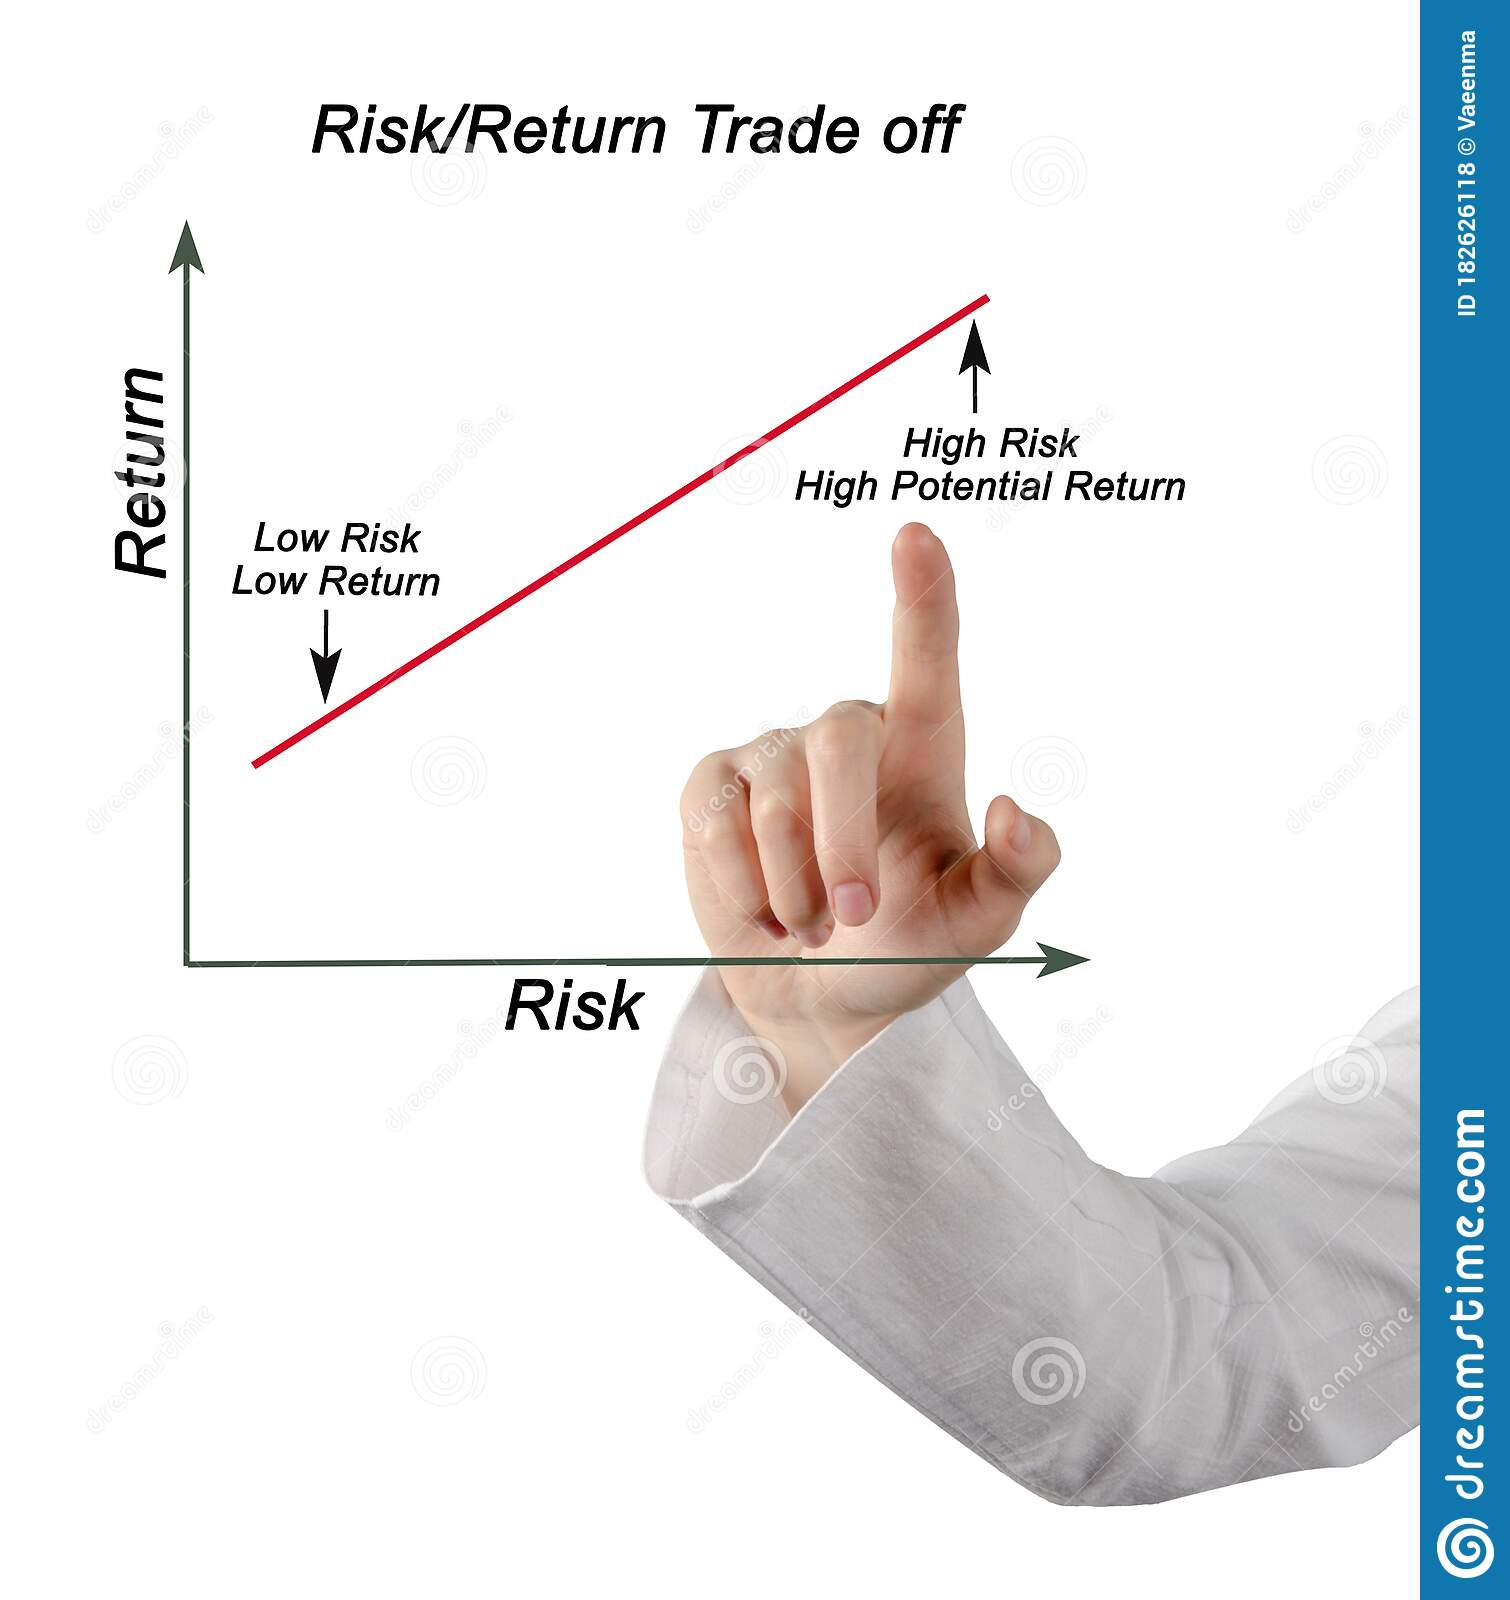

In [8]:
url = 'https://thumbs.dreamstime.com/z/graph-risk-return-trade-off-182626118.jpg'
Image(url, width=400, height=400)

# Monetary Policy, the Current Cycle and Their Relevance for CRE
* Consider the world before the **global financial crisis of 2008/2009** and **COVID-19 of 2019/present**.



* Monetary policy involved central banks, such as the Federal Reserve (through the **Federal Reserve Open Market Committee**), buying and selling short-term government debt, such as short-term U.S. Treasurys.  



* The mechanism by which these actions affected the real economy was through private investment, in particular residential and commercial real estate.  These are called [transmission mechanisms](https://en.wikipedia.org/wiki/Monetary_transmission_mechanism).
    * Consider the supply and demand for money using the "Market for Loanable Funds" representation above.  
    * How does the FOMC impact the price of money?  
    * By expanding or contracting its supply?



* Post-financial crisis monetary policy involves the purchase of **private debt**, such as mortgages, to affect the long-end of the yield curve.  We called this **quantitative easing**.
    * Consider the original [1913 Act](https://www.investopedia.com/terms/f/1913-federal-reserve-act.asp) that created the Federal Reserve system in the U.S.  
    * Does the current Federal Reserve have sufficient tools to conduct monetary policy?  
    * Quantitative easing is an example of a policy that may go beyond the Fed's original mandate.  (See chart below.)
    * What other tools might the Fed have in its quiver?  
        * Average inflation targeting: [AIT](https://www.cnbc.com/2020/08/27/powell-announces-new-fed-approach-to-inflation-that-could-keep-rates-lower-for-longer.html).
        * Nominal GDP targeting: [Scott Sumner](https://www.themoneyillusion.com/category/ngdp-targeting/).
        * Fed creates a market for investors to buy and sell GDP indices: [Roger Farmer](https://www.rogerfarmer.com).
    
    

* In my opinion, the Fed took the wrong path in March 2020 in the face of COVID-19, a natural distaster that created in a [liquidity trap](https://en.wikipedia.org/wiki/Liquidity_trap) similar to the [1906 SF earthquake](https://en.wikipedia.org/wiki/1906_San_Francisco_earthquake). 
    * It was its original function of the lender of last resort (LOLR) that stabilized markets, following Bagehot's original (and ancient) advice.
    
    
    
* The question is now whether the Fed waited too long to begin raising interest rates.
    * Substantive policy debate.



* Tools available to the Fed:
    1. OMO and Fed Funds rate.  (Now standard.)
    2. Discount window and lender of last resort.  (Original function.  Now quantitative easing.)
    3. Reserve requirements.  (Never used.  Interest on excess reserves.)

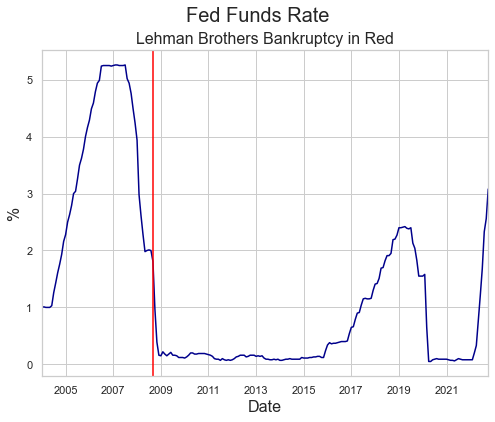

In [9]:
balance = fred.get_series("WALCL", observation_start='2004-01-01') / 1000000
fedfunds = fred.get_series("FEDFUNDS", observation_start='2004-01-01')
fedfunds.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Fed Funds Rate', fontsize=20)
plt.title('Lehman Brothers Bankruptcy in Red', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")

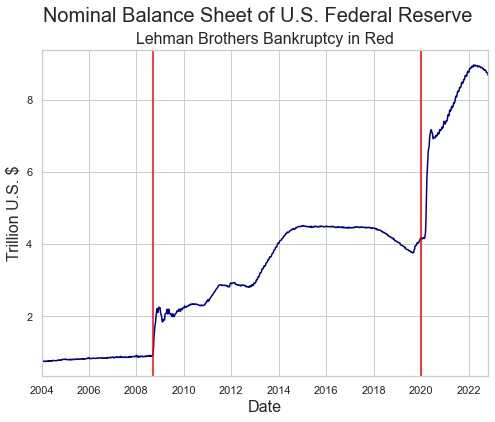

In [10]:
balance.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Nominal Balance Sheet of U.S. Federal Reserve', fontsize=20)
plt.title('Lehman Brothers Bankruptcy in Red', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Trillion U.S. $', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")
plt.axvline(dt.datetime(2020, 1, 1), color="red")

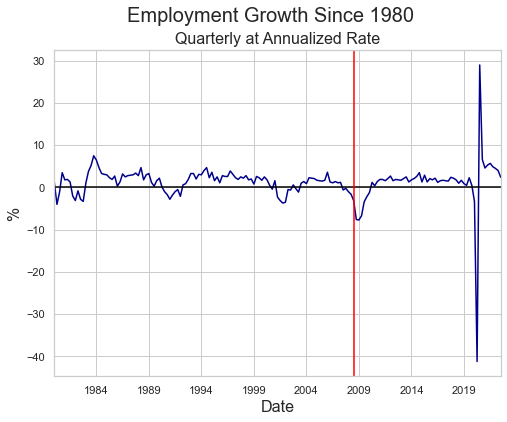

In [11]:
emp_growth = fred.get_series("PRS85006012", observation_start='1980-01-01')
emp_growth.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Employment Growth Since 1980', fontsize=20)
plt.title('Quarterly at Annualized Rate', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(0, color="black")
plt.axvline(dt.datetime(2008, 9, 15), color="red")

Text(0, 0.5, '%')

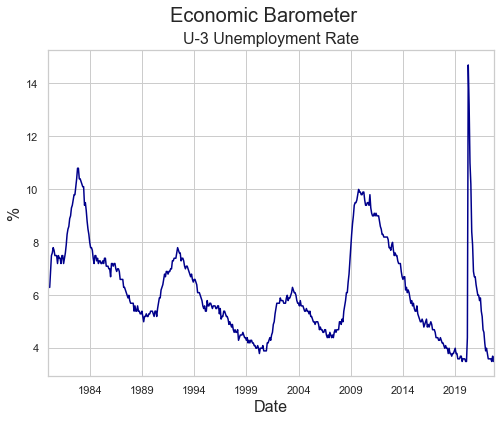

In [12]:
unemp_rate = fred.get_series("UNRATE", observation_start='1980-01-01')
unemp_rate.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Economic Barometer', fontsize=20)
plt.title('U-3 Unemployment Rate', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)

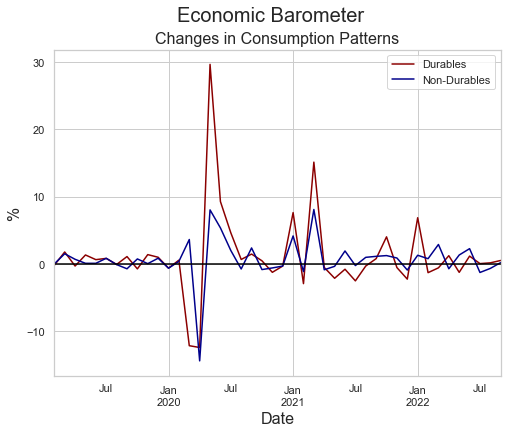

In [13]:
df = {}
df['Durables'] = fred.get_series("PCEDG", observation_start='2019-01-01').dropna()
df['Non-Durables'] = fred.get_series("PCEND", observation_start='2019-01-01').dropna()
df = pd.DataFrame(df)
df = df.pct_change(periods=1).dropna() * 100

colors = (["darkred", "darkblue"])
df.plot(figsize=(8, 6), color = colors)
plt.suptitle('Economic Barometer', fontsize=20)
plt.title('Changes in Consumption Patterns', fontsize=16)
plt.legend()
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(0, color='black')

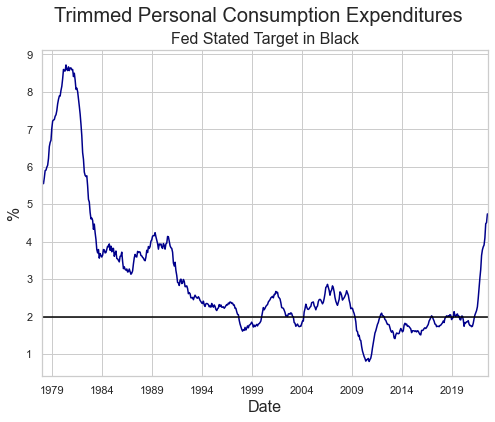

In [14]:
inflation = fred.get_series("PCETRIM12M159SFRBDAL")
inflation.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Trimmed Personal Consumption Expenditures', fontsize=20)
plt.title('Fed Stated Target in Black', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(2, color="black")

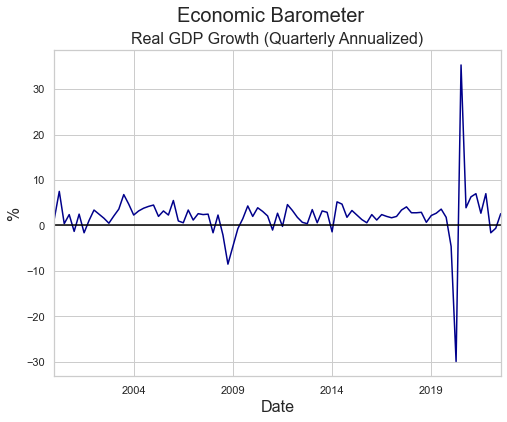

In [15]:
growth = fred.get_series("A191RL1Q225SBEA", observation_start='2000-01-01').dropna()
growth.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Economic Barometer', fontsize=20)
plt.title('Real GDP Growth (Quarterly Annualized)', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(0, color="black")

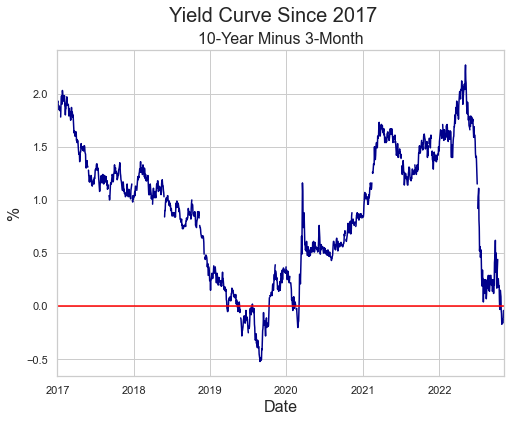

In [16]:
yield_curve = fred.get_series("T10Y3M", observation_start='2017-01-01')
yield_curve.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Yield Curve Since 2017', fontsize=20)
plt.title('10-Year Minus 3-Month', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(0, color="red")

Text(0, 0.5, '')

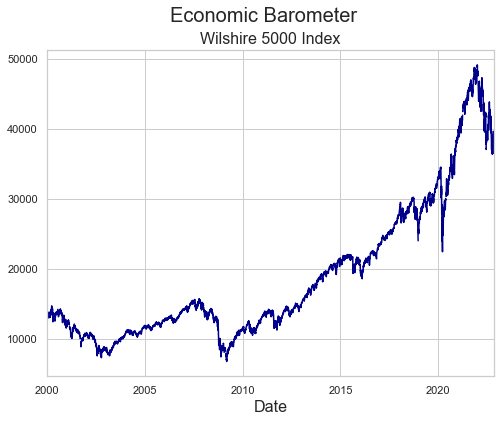

In [17]:
wilshire = fred.get_series("WILL5000PR", observation_start='2000-01-01')
wilshire.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Economic Barometer', fontsize=20)
plt.title('Wilshire 5000 Index', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('', fontsize=16)

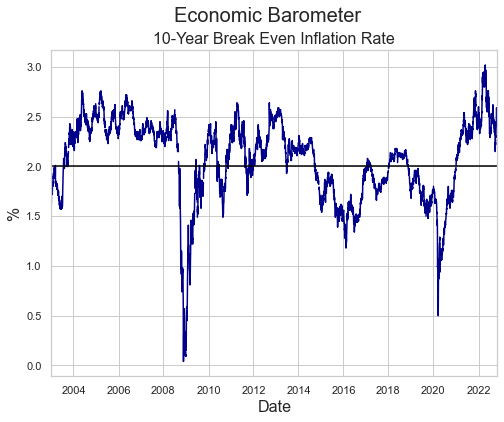

In [18]:
break_even = fred.get_series("T10YIE", observation_start='1990-01-01')
break_even.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Economic Barometer', fontsize=20)
plt.title('10-Year Break Even Inflation Rate', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(2, color="black")

Text(0, 0.5, '%')

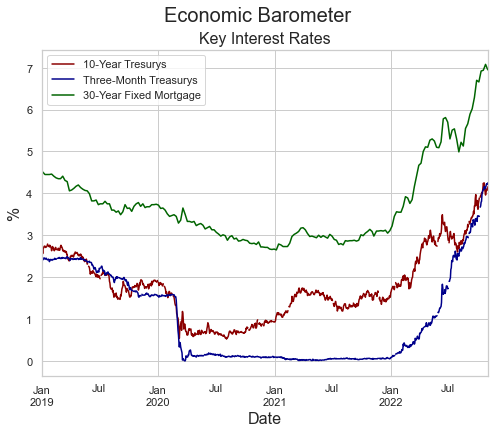

In [19]:
ten_year = fred.get_series("DGS10", observation_start='2019-01-01')
three_month = fred.get_series("DGS3MO", observation_start='2019-01-01')
ffr = fred.get_series("FEDFUNDS", observation_start='2019-01-01')
mortgage = fred.get_series("MORTGAGE30US", observation_start='2019-01-01')
yield_curve = fred.get_series("T10Y3M", observation_start='2019-01-01')

ten_year.plot(c='darkred', label='10-Year Tresurys', figsize=(8, 6), )
three_month.plot(color='darkblue', label='Three-Month Treasurys')
mortgage.plot(color='darkgreen', label='30-Year Fixed Mortgage')
plt.suptitle('Economic Barometer', fontsize=20)
plt.title('Key Interest Rates', fontsize=16)
plt.legend()
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)

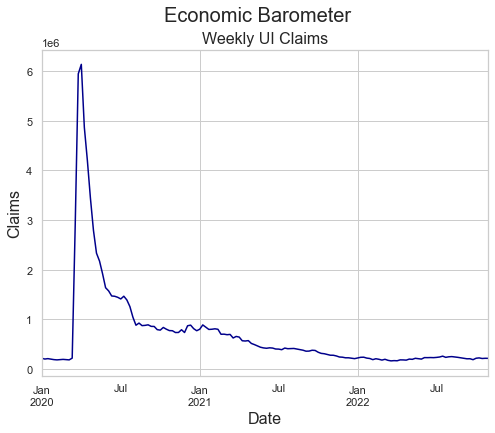

In [20]:
claims = fred.get_series("ICSA", observation_start='2020-01-01')
claims.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Economic Barometer', fontsize=20)
plt.title('Weekly UI Claims', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Claims', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")

Text(0, 0.5, 'Thousands of Adults')

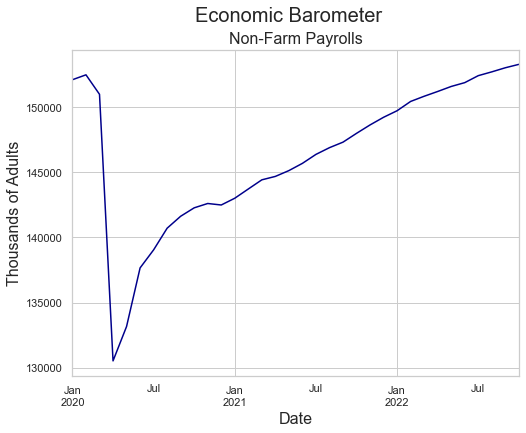

In [21]:
jobs = fred.get_series("PAYEMS", observation_start='2020-01-01')
jobs.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Economic Barometer', fontsize=20)
plt.title('Non-Farm Payrolls', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Thousands of Adults', fontsize=16)

## Why Does this Matter?  
* You have to consider these ideas when doing a DCF model.

# Chapter 10: DCF and NPV

* What is an financial asset worth?  
    * Finacial assets have no intrinsic value.  **Their value is relative to available alternatives**.  (See [ketchup economics](https://www.investorschronicle.co.uk/2016/04/07/comment/in-praise-of-ketchup-economics-coZWQOc9NiittUVDTztU6J/article.html).)  
    * Their values are determined in a market by **supply and demand**.
    * The **method of DCF** is an *approach to valuation*.  **It is a model but not an algorithm**.
    * **Critical point**:  In real estate, cash flows may be independent of the price paid for an asset.
        * Why?  Cash flows are determined by supply and demand in a local market, as well as the prowess and ability of the owner/operator.  
        * Supply and demand in a market over time are largely independent of the price paid for a single asset in that market.   
        * Consider [Hudson Yards](https://www.hudsonyardsnewyork.com) in NYC.  Why might a developer and investor be interested in developing and owning an entire market like Hudson Yards?
        * Now consider the impact of **COVID**, which could not be forecast at the time decisions about Hudson Yards were made.  
    * As a result, prices paid **today** drive expected returns **in the future** that may not materialize.
        * An idea to consider: [the winner's curse](https://www.investopedia.com/terms/w/winnerscurse.asp).



* Example: 
    * NOI: 10,000
    * End of Period (EOP) Sale Price: 105,000
    * Purchase Price: 100,000
    * Return is (NOI + Change in Value) / Purchase Price
        * (10,000 + 5,000) / 100,000 = 15%



* Suppose instead you paid 105,000
    * (10,000 + 0) / 100,000 = 10%  
        * The book discounts, but I want to make this an easier example.

## The Inverse Relation Between Expected Returns and Values
* **Expected returns are inversely related to today’s prices**. 
    * Expected future cash flows (including resale) occur in the future, regardless of how much you pay today for the asset. 
    * They are determined by future economic factors that are independent of how much you pay today for the asset. 
    * **Future rents are determined by future supply and demand in the future**.  
    * Future resale prices are determined by future rents the next buyer expects after acquisition and that buyers’ IRR and their OCC at the time of resale. 
    * None of these factors is influenced by the price you pay today for the property.
    * Uncertainty and the risk-return trade-off.

## Discounted Cash Flow Valuation
* Standard valuation model is the discounted cash flow (DCF).
    * It is a model and **not an algorithm** and consists of three steps:



1. Forecast the expected future cash flows.
2. Ascertain the required total return.
3. Discount future cash flows to present value at the required total return.



* $V$ is present value based on its expected future performance:
$V = \displaystyle{\frac{E_0[CF_1]}{[1+E_0[r]]^1}+\frac{E_0[CF_2]}{[1+E_0[r]]^2}}+...+\frac{E_0[CF_{T-1}]}{[1+E_0[r]]^{T-1}}+\frac{E_0[CF_{T}]}{[1+E_0[r]]^{T}}$



* $CT_t$ are net cash flows (after expenses) in period t, which may be lumpy.



* $𝐸_0[r]$ is expected multi-period return as of time zero (today), which includes the OCC for the investment.



* $T$ is terminal period in the expected holding period, and $CF_T$ would include the net resale value of the property, as well as net cash flows in that period. 



* Value today is inversely related to expected future returns, $E_0[r]$  
    * Why?  
    * This does not sound intuitively correct **but it is**.



* Returns are percentage changes in a value, $\displaystyle{\frac{V_{t+1}-V_t}{V_t}=\frac{\Delta V}{V}}$



* Consider DW: more capital chasing a fixed stock of assets.
    * More demand, given a fixed stock, will increase values (or prices) today, $V_t$.
    * As a result, *ex ante* returns will decrease, absence changes in $V_{t+1}$, and future values are determined in the future.



* Consider loanable funds.
    * Given a fixed supply of capital, a decrease in demand decreases the real interest rate, which increases the number NPV positive projects.

## Greater Fool Theory: Always someone more foolish (than you)
* A bemusing idea, but **dated and largely wrong**.  



* Investors have different strategies and risk preferences, but those preferences cannot be observed.  



* As a result, investors place different values on the same properties.



* Different valuations imply a potential **gain from trade**, unless transactions costs are too large.
    * Recall this is a basic function of finance: matching the risk preferences (or tolerances) of heterogeneous investors.



* *Someone Smarter Theory*: We can operate this property better than you can.
    * Gains to trade: Consider **BX's acquisition of EOP**.

## The Decomposition of Total Returns
* $r = r_f + RP$: total return is the sum of risk-free rate and risk premium.



* Long-term (10 years) leases with certain payments (monthly rent).  



* Consider this idea in the era of **COVID-19**.

## 10.3: DCF is Direct Capitalization
* **Short cut**: 
    * $\displaystyle{\text{Value} = \frac{\text{NOI}}{\text{cap rate}} \Rightarrow \text{cap rate}=\frac{\text{NOI}}{\text{Value}}}$
    * Therefore, cap rates are yields: NOI as a share of value if a fully-leased property could be converted to cash immediately.
    * Consider **COVID**: it impacts both NOI and value, so it is not be surprising to see little change in cap rates, especially given **COVID** monetary policy.



* Gross income multiplier for small properties:
    * Given uncertainties in operating expenses.


* Uncertain cash flows must be discounted more heavily to reflect the uncertainty

## 10-A
* Real estate is a long-lived asset that investors hold for extended periods of time (five to seven to ten years).



* Transactions costs can be substantial.



* Earning returns through the successful operation of properties increases growth paths of rents and lowers periods of vacancy.



* Performance attribution.
    1.  Initial cash-flow yield (IY)
    2.  Subsequent cash-flow changed (CFC)
    3.  Yield or valuation change (YC)

# Chapter 11: Valuation

* Pro forma (or income) statements are intuitive.
    * See PPT slides.



* Components of the pro forma, however, can involve large expenses (capital improvements) that are depreciated (or amoortized) over time.  
    * In other words, they are one-time, lump-sum expenses.
    * The benefits of which are realized over time rather than at a point in time.
    



* Exhibit 11-2: Inflation has exceeded NOI growth for an extended period of time in the U.S.
    * This period of time includes periods of high inflation and low inflation.
    * Is CRE a hedge against inflation?
        * Not according to [Bill Wheaton](https://www.cbre-ea.com/publications/deconstructing-cre-post/deconstructing-cre/2017/07/21/has-real-estate-been-a-good-hedge-against-inflation-will-it-be-in-the-future)
            * Retail can adapt most rapidly to current economic conditions (in both directions).
            * Office, by construct, is the least adaptable, but because of co-working a substantial share of it will have real-time pricing.




* Exhibit 11-5:  Using "T-Bills" as the risk free rate, $r_f$, we can calculate the return premium, $RP$.
    * Consider real estate: higher $RP$ than long-dated bonds but lower than a broad measure of stocks.
    * Lower volatility than both.
    * Recall that Sharpe ratio measures the ratio of a unit of return $\mu$ to a unit of risk $\sigma$, calculated as $\displaystyle{\frac{\mu}{\sigma}}$.  
        * Compare the the Sharpe ratios across these asset classes, but remember real estate is **illiquid** and its higher Sharpe ratio may capture the illiquidity risk. 

# Real Estate Finance: Themes to Date
* Economics and finance drive the mathematics.



* Economics and finance allow us to think logically about how markets might perform.
    * Excel is tool.
    * Like death and taxes, it will always be with us.
    * But there are better and free tools available to do advanced modeling.
    * One might want to stress test a portfolio using Monte Carlo simulation.
    * One might want to backtest an investment strategy.
    * One might want to simulate potential performance using open sourced data.  (See Savage, Vo, and Zhao.)
    * The future lies with open source tools, such as R and Python.




### We discount the future because it may not occur.




### We recognize that there is a trade-off between *ex ante* return and risk, and *ex post* we may lose money.



### We are able to apply all of these themes to commercial real estate, as in Chapters 21 and 22.



### Capital is global, but real estate markets are local.



### Real estate markets have complex contracts that we call leases, governing the responsibilities of all parties (landlord, tenant and their representatives).



### Real estate assets are highly heterogeneous and illiquid.
#### They provide potential yield (cash flows) and growth (price appreciation) that may be uncorrelated with equities and bonds.



### An Introduction to Macroeconomics
* *Microeconomics*: the study of individual markets.
* *Macroeconomics*: the study of aggregate output, its fluctuations and their drivers.
* *Econometrics*: the use of statistical models to examine conjectures that arise from theory.



* We have touched on elements of each of these (and will continue to do so in your upcoming courses).
    * Microeconomics: DiPasquale-Wheaton
    * Macroeconomics: interest rate determination (via loanable funds market) and themes in finance
    * Econometrics (now data analytics more generally): modern portfolio theory and 3135
    * *I personally see no difference in any of these topics*
    
    

* The U.S. Federal Reserve was created by a 1913 Act following a large financial crisis and recession in 1907.  It is technically the banker's bank.  
    * Originally, it used the standard tool of the discount window to lend to banks under the gold standard of convertability.
    * In 1933, the gold standard was suspended.
    * During WWII, the Fed began explicit interest rate setting.
    * It was made operationally independent of the U.S. Treasury in the early 1950's under admendments to 1913 Act.
    * The role of the discount window substantially diminished, as did change the reserve ratio.  Primary focus was on OMOs.
    * **Not transparent**.  No explicit statements about overnight Fed Fund rate.  No forward guidance.  No regular testimony to Congress.
    * During the GFC, new tools were needed.  Transparency itself was seen as a tool.  

# Chapter 21: Real Estate and Portfolio Theory

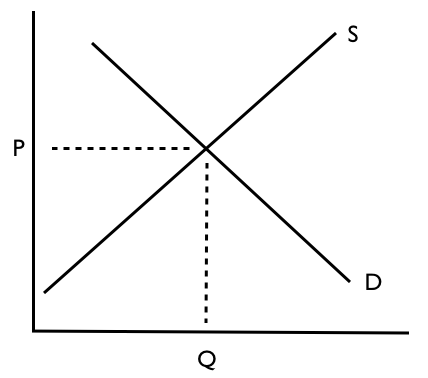

In [22]:
url = 'https://upload.wikimedia.org/wikipedia/commons/4/48/Supply-Demand-Graph.png'
Image(url, width=400, height=400)

## Demand and Supply Curves as They Determine Prices in Equilbirum
* Demand: Consumers maximimzing utility of consumption, $U(c_1,c_2)$, subject to their income but faced with uncertainty (and generally risk averse).
    * Income falls, generally consume less **of everything**: Keynes' paradox of thrift.
    * If the price of $c_1$ changes, offsetting income and substitution effects.



* Supply: Firms maximizing profits, $\pi=R(q) - C(q)$, subject to considering how their competitors act and uncertainty.
    * Lots of really interesting ideas here from Industrial Organization economists studying competition in markets.
    * Horizontal integration: CBRE and C&W seek to merge.
    * Vertifical intergration (REITs).

## Two Key Ideas: A Return and an Average



### A Return
* (What I earned) / (What I paid) $-1$.



* Consider the idea of a return on a dividend-paying equity: $r_{t+1} = \displaystyle{\frac{p_{t+1} + d_t}{p_t}-1} = \frac{p_{t+1}-p_t}{p_t}+\frac{d_t}{p_t} = $ **capital gain** + **yield**.
    * Setting aside expectations of the future, returns can be decomposed into a **capital gain** and a **yield**.
    * In CRE, the gain is an increase in the value of a building, while the yield is monthly rent (as a share of total value).



### An Average
* $\displaystyle{\frac{1+2}{2}=\frac{1}{2} \cdot 1+ \frac {1}{2} \cdot2=1.5}$.



* $\displaystyle{w_1 \cdot 1+ w_2 \cdot2=}$ ? where $w_1+w_2=1$ or $w_2=1-w_1$.
    * An average is weighted sum.
    * Suppose we can can vary $w_1$ by an infinitesimal amount.
    * This is core idea behind portfolio: costlessly alter assets in a portfolio.




### The Goal
* The goal of this chapter is to relate real estate to the broader ideas in **modern portfolio theory (MPT)**, in which stocks, bonds, and cash are asset types.
    * Each asset type has a return.
    * The returns are correlated.



* Investors, whether individuals or institutional entities, construct portfolios of assets that include stocks, bonds, cash and real estate.  



* It lies at the heart of portfolio optimization that won Harry Markowitz a Nobel Prize in Economics in 1990.   
    * It was developed largely to examine stocks (equities), but its application has expanded far beyond this asset class.  
    * As part of the broader undertaking of portfolio optimization, it is used to explain most core concepts in equilibrium asset pricing.
    * Asset Classes:
        * Cash
        * Bonds
        * Stocks (or equities)
        * Real Estate (a differentiated asset type)



### Portfolios
* Consider a portfolio, $P$, with $n$ assets, indexed as $_i$.  



* Total return on the portfolio is $r_p$, where $E[r_p] = \sum_i w_i \cdot E[r_i] \ni \sum_i w_i = 1$
    * In words, the expected total return on the portfolio is simply a weighted sum of the expected returns of the individual assets.
        * Long position: $w_i > 0$
        * Short position: $w_i < 0$
        * We will focus on situations where $w_i > 0$



* Total risk is $\sqrt{Var[r_p]}$, which depends on the correlation patterns among the assets in the portfolio.



* Problem statement (or use case): Minimize risk subject to achieving a stated level of return.
    * Risk is backward looking.  It is the *ex post* measure of the standard deviation of returns on the assets in a portfolio.
    * Returns are forward looking.  They are the *ex ante* or expected returns on the assets in a portfolio.
        * Expected returns are weighted averages of the return on the assets in the portfolio.



* Indifference curves and portfolio dominance.
    * See slides.
    * Remember the basic principle:
        * I am better off if I can reduce risk at the same level of return.
        * I am better off if I can increase return at the same level of risk.
        * I am better off if I can combine the two in some manner through diversification.



* Portfolio diversification is a *correlation game* based on correlation patterns in a portfolio.



### Slide 19: Convexity
* [A convex space](https://en.wikipedia.org/wiki/Convex_set): Never cross the boundary.



* Consider the returns on two assets is some portfolio, $P$: $r_1$ and $r_2$ and their associated weights, $w_1$ and $w_2$.
    * $r_P = w_1 \cdot r_1 + w_2 \cdot r_2$
    * $w_1 + w_2 = 1 \rightarrow w_2 = 1 - w_1 \rightarrow r_P = w_1 \cdot r_1 + (1 - w_1) \cdot r_2$
    * Consider the idea of varying $w_1$ continuously from 1 to 0.  
    * Such variation creates the convex space: when $w_1 =1 $, $r_1$ dominates and when $w_1 = 0$, $r_2$ dominates.
    * Trivial to extend to multiple assets, whose returns are $r_i$ with weights $w_i$.
        * $E[r_p] = \sum_i w_i \cdot E[r_i] \ni \sum w_i = 1$



* Companies mentioned in this lecture:
    * [Commodities Corporation](https://en.wikipedia.org/wiki/Commodities_Corporation)
    * [Long Term Capital Management (LTCM)](https://en.wikipedia.org/wiki/Long-Term_Capital_Management)

## A Correlation Game
* Suppose there is portfolio, $P$, such that each asset in the portfolio has an equal weight, and there are $n$ assets $\Rightarrow w_i = 1/n$ $\forall i$.



* Certainty: Variance does not matter.



* Uncertainty: Variance does matter.



* Uncertainty with a portfolio, $P$: Only covariance matters.  



* Therefore, diversification is a covariance (or correlation) game.



#### Simple Proof (Triangle Inequality)
* Let the risk of portfolio, $P$, be denoted by $\sigma^2_p$.


* $\displaystyle{\sigma^2_p = \sum_{i, j} w_i w_j c_{ij} = \sum_i w^2_i \sigma^2_i + \sum_{i \ne j} w_i w_j \sigma_{ij} \le n^{-2} T + n^{-2} \sum_{i \ne j}c_{ij} = n^{-2} T + (1-n^{-1}) c}$ for some trivial threshold $T$ if we assume:
    * Assume $c_{ij} = c$ where $c_{ij}$ is the covariance of returns between assets $i$ and $j$, and $w_i = 1/n$ $\forall i$


* What happens as the number of assets becomes infinitely large and our ability to invest in infinitely small amounts of them:
    * $\displaystyle{\lim_{n \rightarrow \infty} \{n^{-2} T + (1-n^{-1}) c\} = c}$


* **Diversification is a covariance game**, $c$.


* We like measures that lie between $[-1, 1]$ that we call correlations $\Rightarrow$ diversification is a correlation game. 

# Chapter 22: Equilibrium Asset Pricing
* The goal of this chapter is to describe the idea of asset pricing (or value) that would obtain in equilibrium.



* The practical uses for asset price theory are:
    1. Tactical: identify mispriced assets
    2. Strategic: identify risk factors 
    3. Benchmarking: identify a standard against which to measure portfolio performance



* **Exhibit 22-2**: The importance of cap rates (rather than cash flows).




## The Capital Asset Pricing Model (CAPM): A Statistical Application of MPT
* Let $r_i$ denote the rate of return to asset $i$, $r_f$ denote the known rate of return on a risk-free asset (for example, short-term US government debt), and $r_m$ denote the rate of return to a portfolio (or a market) that includes $i$.  



* The following equation can be derived:
    * $E(r_i)-r_f = \alpha + \beta \cdot (E(r_{Mi})-r_f)$



* Here, $E(\cdot)$ denotes an expected value (because this is a forward-looking prediction).  


* $\beta$ captures the sensitivity of an asset’s returns to the returns to a portfolio or to the market on which an asset trades.  
    * In other words, it **non-diversifiable risk**.  
    
    
    
* $\alpha$ measures an asset $i$’s **excess (or abnormal) returns**.



* Phrases you may have heard: 

    1. The stock's beta is high
    2. The hedge fund is chasing alpha
    


* In informationally-efficient markets, $\alpha \rightarrow 0$ and $\beta \rightarrow 1$.




## Isn't CAPM Wrong?
> "All models are wrong, but some models are useful."  *George Box*



> "We could always flip a coin, but we don't." *Tim Savage*

In [23]:
from tabulate import tabulate
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

## A Brief Introduction to Markov Processes

* Markov processes are already familiar to anyone with a calendar.
* Everything I need to know about **tomorrow** is contained by my knowledge of **today**.
* Markov processes are a fundamental building block of time series.

In [24]:
print("The Calendar: A Deterministic Markov Transition Matrix")
table = [[" ", "S", "M", "T", "W", "T", "F", "S"],
         ["S", "0", "1", "0", "0", "0", "0", "0",],
         ["M", "0", "0", "1", "0", "0", "0", "0",],
         ["T", "0", "0", "0", "1", "0", "0", "0",],
         ["W", "0", "0", "0", "0", "1", "0", "0",],
         ["T", "0", "0", "0", "0", "0", "1", "0",],
         ["F", "0", "0", "0", "0", "0", "0", "1",],
         ["S", "1", "0", "0", "0", "0", "0", "0",],]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

The Calendar: A Deterministic Markov Transition Matrix
╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│   │ S │ M │ T │ W │ T │ F │ S │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ S │ 0 │ 1 │ 0 │ 0 │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ M │ 0 │ 0 │ 1 │ 0 │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ T │ 0 │ 0 │ 0 │ 1 │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ W │ 0 │ 0 │ 0 │ 0 │ 1 │ 0 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ T │ 0 │ 0 │ 0 │ 0 │ 0 │ 1 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ F │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 1 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ S │ 1 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛



In [25]:
print("Day of Week Vector: Today is Monday")
table = [["S", "M", "T", "W", "T", "F", "S"],
         ["0", "1", "0", "0", "0", "0", "0",]]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

Day of Week Vector: Today is Monday
╒═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ S │ M │ T │ W │ T │ F │ S │
├───┼───┼───┼───┼───┼───┼───┤
│ 0 │ 1 │ 0 │ 0 │ 0 │ 0 │ 0 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╛



### How do we iterate the day of the week?  
* Today is Monday.  This is called the state of the system.



* What is tomorrow?  We want to iterate the system through time.



* day of week vector * Markov transition matrix = ?

In [26]:
# Let's find out.

MT = np.matrix('0 1 0 0 0 0 0; 0 0 1 0 0 0 0; 0 0 0 1 0 0 0; 0 0 0 0 1 0 0; 0 0 0 0 0 1 0; 0 0 0 0 0 0 1; 1 0 0 0 0 0 0')
dow = np.matrix('0 1 0 0 0 0 0')

print("Markov Transition Matrix")
print(MT)
print()
print("Today")
print(dow)
print()
print("Tomorrow")
print (dow * MT)
print()
print("The Day After Tomorrow")
print (dow * MT * MT)
print()
print("The Day After Tomorrow Using Linear Algebra")
print (dow * np.linalg.matrix_power(MT, 2))

Markov Transition Matrix
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0]]

Today
[[0 1 0 0 0 0 0]]

Tomorrow
[[0 0 1 0 0 0 0]]

The Day After Tomorrow
[[0 0 0 1 0 0 0]]

The Day After Tomorrow Using Linear Algebra
[[0 0 0 1 0 0 0]]


### Why are these useful in finance?
* Burton Malkiel's *A Random Walk Down Wall Street*.



* Set an arbitrary starting point and iterate the system using a simple Markov process.



* Each second, this Markov process can move up 1 or it can move down, which it does at random.



* Pr(up) = Pr(down) = 0.5.

Text(0.5, 0, 'Seconds')

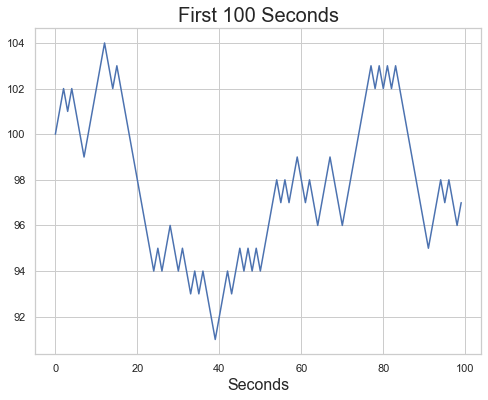

In [27]:
random.seed(1234)

pos = 100  
walk = [pos] 
nsteps = 10000 
for i in range(nsteps):
    step = 1 if np.random.randint(0, 2) else -1
    pos += step
    walk.append(pos)

plt.figure(figsize=(8, 6))
plt.plot(walk[0:100])
plt.title('First 100 Seconds', fontsize=20)
plt.xlabel('Seconds', fontsize=16)

Text(0.5, 0, 'Seconds')

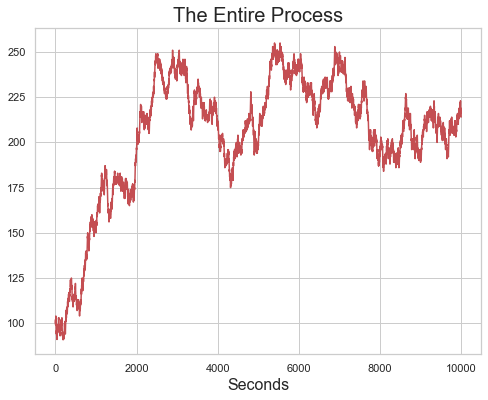

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(walk, 'r')
plt.title("The Entire Process", fontsize=20)
plt.xlabel('Seconds', fontsize=16)

### What does this look like?

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, '$')

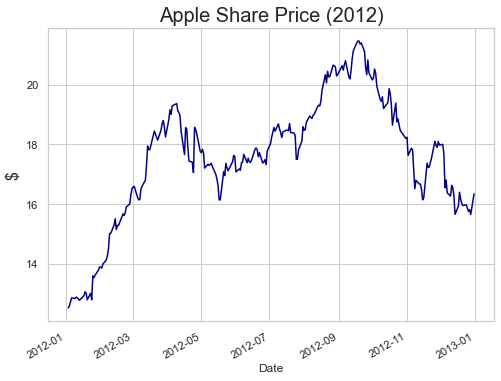

In [29]:
start, end = "2012-01-01", "2013-01-01"
aapl = yf.download('aapl', start=start, end=end)['Adj Close']
aapl.plot(color = 'darkblue', figsize=(8, 6))
plt.title('Apple Share Price (2012)', fontsize=20)
plt.ylabel('$', fontsize=16)

## Examples
* Markowitz's other key insight: $E(r_i)-r_f = \alpha + \beta \cdot (E(r_{Mi})-r_f)$ is a statistical application:
    * $r_i = \alpha + \beta \cdot r_{Mi} + \epsilon_i$, where $\alpha$ is the intercept and $\beta$ is the slope.



* CAPM Notebook